# Synthetic Case Study example with different noise models (uncorrelated/correlated)
Demonstrates the use of different noise models with tTEM data using an example using inverting data obtained from synthetic reference model 



In [1]:
try:
    # Check if the code is running in an IPython kernel (which includes Jupyter notebooks)
    get_ipython()
    # If the above line doesn't raise an error, it means we are in a Jupyter environment
    # Execute the magic commands using IPython's run_line_magic function
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')
except:
    # If get_ipython() raises an error, we are not in a Jupyter environment
    # # # # # # # # # # # # # #%load_ext autoreload
    # # # # # # # # # # # # # #%autoreload 2
    pass

import integrate as ig
# check if parallel computations can be performed
parallel = ig.use_parallel(showInfo=1)

import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
hardcopy=True



Notebook detected. Parallel processing is OK


## Create The reference model and data
A simple three layer reference model is constructed, where the thickness of layer 2 varies. Them The corresponding noise free data is computed.

In [2]:
# select the type of referenc model
case = '3layer'        # A 3 layer referennce model
#case = 'wedge'        # A 'wedge' reference model
z_max = 60             # Max thickness of the model 
dx=1                   # The layer thickness
rho = [120,10,120]
if case.lower() == 'wedge':
    # Make Wedge MODEL
    M_ref, x_ref, z_ref, M_ref_lith = ig.synthetic_case(case='Wedge', wedge_angle=10, z_max=z_max, dz=.5, x_max=100, dx=dx, z1=15, rho = rho)
    M_ref, x_ref, z_ref, M_ref_lith = ig.synthetic_case(case='Wedge', wedge_angle=10, z_max=z_max, dz=.5, x_max=200, dx=dx, z1=15, rho = rho)
elif case.lower() == '3layer':
    # Make 3 layer MODEL
    M_ref, x_ref, z_ref, M_ref_lith = ig.synthetic_case(case='3layer', dx=dx, rho1_1 = rho[0], rho1_2 = rho[1], x_max = 100, x_range = 10)
    #M_ref, x_ref, z_ref, M_ref_lith = ig.synthetic_case(case='3layer', dx=dx, rho1_1 = rho[0], rho1_2 = rho[1], x_max = 200, x_range = 20)
    M_ref, x_ref, z_ref, M_ref_lith = ig.synthetic_case(case='3layer', dx=dx, rho1_1 = rho[0], rho1_2 = rho[1], x_max = 1000, x_range = 100)
    M_ref, x_ref, z_ref, M_ref_lith = ig.synthetic_case(case='3layer', dx=dx, rho1_1 = rho[0], rho1_2 = rho[1], x_max = 1000, x_range = 50)

# Create reference data
f_data_h5 = '%s_%d' % (case,z_max)    
thickness = np.diff(z_ref)
# Get a GEX file to use for creation of data
file_gex = ig.get_case_data(case='DAUGAARD', filelist=['TX07_20231016_2x4_RC20-33.gex'])[0]

# Compute the noise free reference data
D_ref = ig.forward_gaaem(C=1./M_ref, thickness=thickness, file_gex=file_gex)

Getting data for case: DAUGAARD
--> Got data for case: DAUGAARD


In [3]:
M_ref.shape

(1000, 60)

### Plot the reference model and data

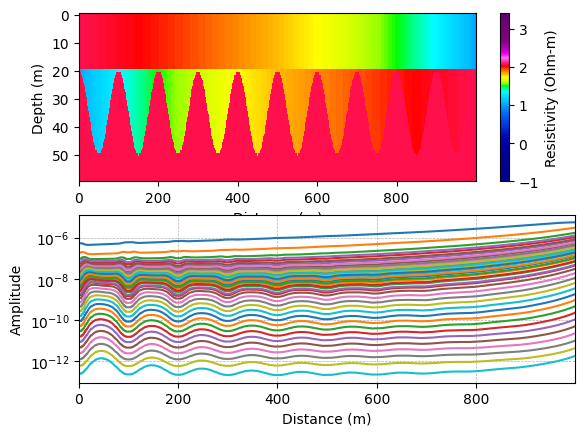

In [4]:
cmap, clim = ig.get_colormap_and_limits(cmap_type='resistivity')

plt.subplot(2,1,1)
xx_ref, zz_ref = np.meshgrid(x_ref, z_ref)
#plt.pcolormesh(xx_ref, zz_ref, M_ref.T, cmap='jet', vmin=clim[0], vmax=clim[1])
plt.pcolormesh(xx_ref, zz_ref, np.log10(M_ref.T), cmap=cmap, vmin=np.log10(clim[0]), vmax=np.log10(clim[1]))
plt.xlim([x_ref.min(), x_ref.max()])
plt.xlabel('Distance (m)')
plt.ylabel('Depth (m)')
#plt.axis('equal')
plt.gca().invert_yaxis()
plt.colorbar(label='Resistivity (Ohm-m)')

plt.subplot(2,1,2)
plt.semilogy(x_ref, D_ref)
plt.xlim([x_ref.min(), x_ref.max()])
plt.xlabel('Distance (m)')
plt.ylabel('Amplitude')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)



### Create prior model and data

Here a prior model is defined (a 3 layer model). The prior model realizations are generated, followed by prior data realizations.


Using file_basename=TX07_20231016_2x4_RC20-33
prior_data_gaaem: Using 32 parallel threads.


prior_data_gaaem: Time=1687.8s/2000000 soundings.  0.8ms/sounding, 1185.0it/s


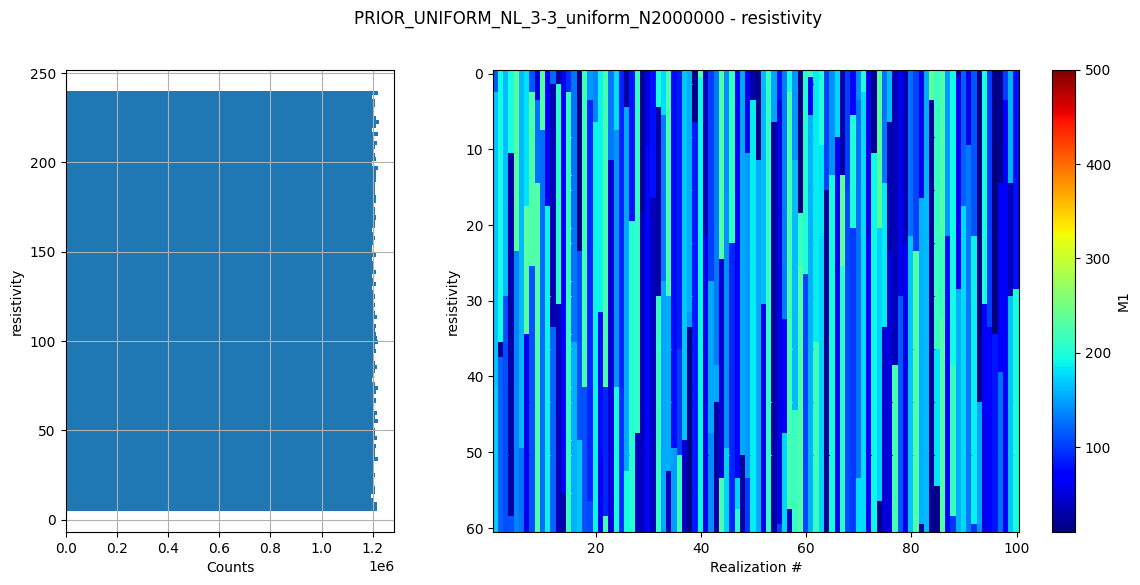

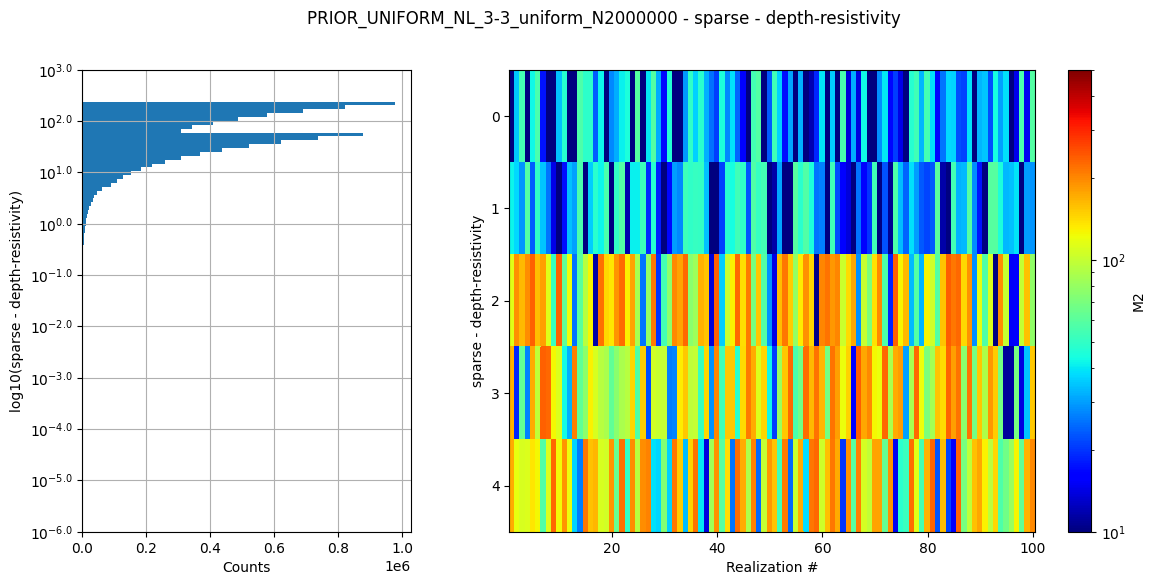

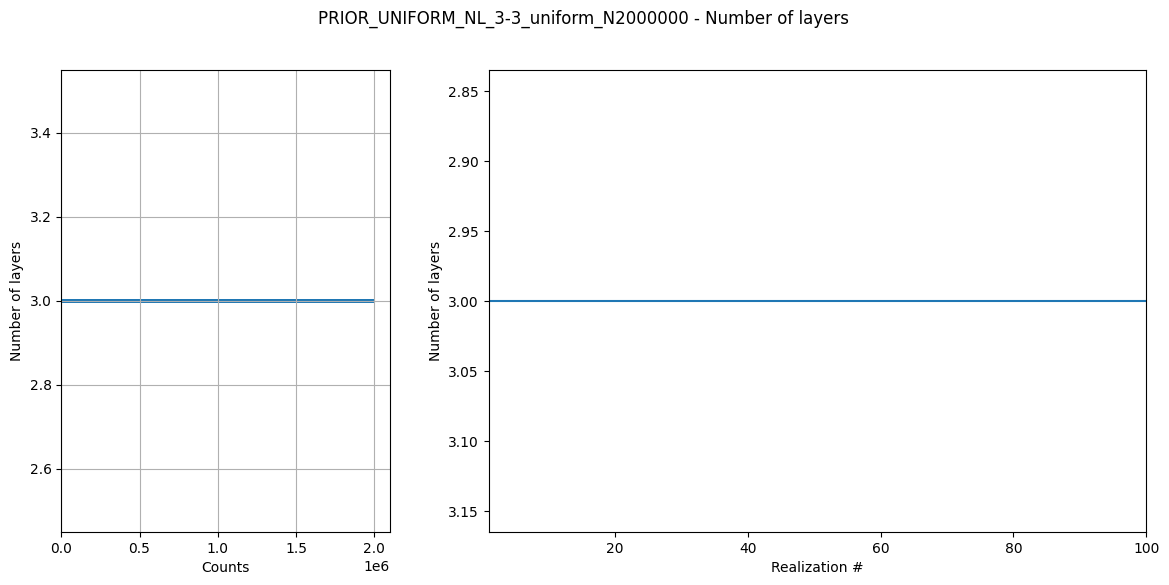

In [5]:
N=2000000 # sample size 
#N= 100000 # sample size 
NLAY_min=3
NLAY_max=3

f_prior_data_h5='PRIOR_UNIFORM_NL_%d-%d_uniform_N%d_TX07_20231016_2x4_RC20-33_Nh280_Nf12.h5' % (NLAY_min, NLAY_max, N)

# make prior model realizations
f_prior_h5 = ig.prior_model_layered(N=N,
                                    lay_dist='uniform', z_max = z_max, 
                                    NLAY_min=NLAY_min, NLAY_max=NLAY_max, 
                                    RHO_dist='uniform', RHO_min=0.5*min(rho), RHO_max=2*max(rho))

# make prior data realizations
f_prior_data_h5 = ig.prior_data_gaaem(f_prior_h5, file_gex)

# Plot some statistics about the prior model parameters
ig.plot_prior_stats(f_prior_h5)

## Three ways to describe uncorrelated noise

In [6]:
# The basic noise model: 3% relative noise and a noise floor at 1e-12
rng = np.random.default_rng()
d_std = 0.03 # standard deviation of the noise
d_std_base = 1e-12 # base noise
D_std = d_std * D_ref + d_std_base

# Add a realization of of the noise model to the noise free data, and treat these as 'observed' reference data. 
D_noise = rng.normal(0, D_std, D_ref.shape)
D_obs = D_ref + D_noise
# Cd is a diagnoal matrix with the standard deviation of the data

### Setup data with different types of noise assumptions.

In [7]:
# If a single correlated noise model is used, 
# it can represented by be the mean of the standard deviation of the data.
# This is though an approximation.
Cd_single = np.diag(np.mean(D_std, axis=0)**2)
Cd_single = np.diag(D_std[0]**2) 



# The full data covariance matrix is represented by a 3D array of shape (ns,nd,nd)
# Using this type of noise should provide identical results to using d_std, only slower as 
# the full covariance matrix is used.
# This type of noise model is useful when the noise is not the same for all data points,
# and the noise is correlated.
ns,nd=D_std.shape
Cd_mul = np.zeros((ns,nd,nd))
for i in range(ns):
    Cd_mul[i] = np.diag(D_std[i]**2)

# Wrie the three differet types of noise models to hdf5 files
f_data_h5_arr=[]
name_arr = []

f_out = ig.save_data_gaussian(D_obs, D_std = D_std, f_data_h5 = 'data_uncorr.h5', id=1, showInfo=0, delete_if_exist=True)
f_data_h5_arr.append(f_out)
name_arr.append('Uncorrelated noise')

f_out  = ig.save_data_gaussian(D_obs, Cd=Cd_single, f_data_h5 = 'data_corr1.h5', id=1, showInfo=0, delete_if_exist=True)
f_data_h5_arr.append(f_out)
name_arr.append('Correlated noise - mean')

f_out = ig.save_data_gaussian(D_obs, Cd=Cd_mul, f_data_h5 = 'data_corr2.h5', id=1, showInfo=0, delete_if_exist=True)
f_data_h5_arr.append(f_out)
name_arr.append('Correlated noise - individual')

Data has 1000 stations and 40 channels
Adding group data_uncorr.h5:D1 
Data has 1000 stations and 40 channels
Adding group data_corr1.h5:D1 
Data has 1000 stations and 40 channels
Adding group data_corr2.h5:D1 


mean T1=-42.07659
mean T2=-42.07659
mean T3=-42.07659
t1, t2, t3 = 0.406319, 0.572369, 0.563601
SLOWDOWN = 1.000000, 1.408669, 1.387091


/home/au11687/integrate/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


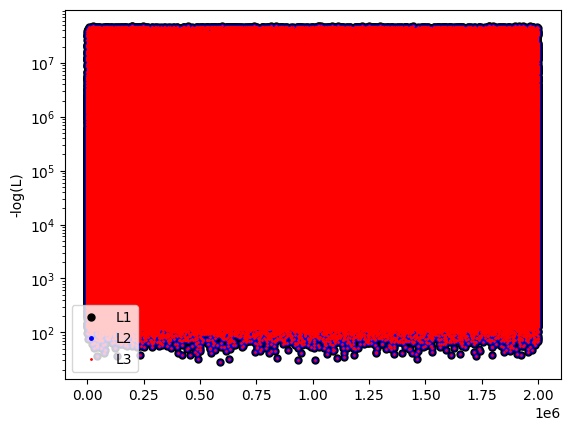

In [8]:
import time as time
# test likelhood
doTest = True
if doTest:
    id=0
    d_obs = D_obs[id]
    #d_obs[11]=np.nan
    d_std = D_std[id]

    C_single = np.diag(d_std**2)+1e-18

    with h5py.File(f_prior_data_h5, 'r') as f:
        D = f['/D1'][:]
        
    #D = D_ref
    t0=time.time()
    L1 = ig.likelihood_gaussian_diagonal(D, d_obs, d_std)
    t1 = time.time()-t0
    L2 = ig.likelihood_gaussian_full(D, d_obs, Cd_single, useVectorized=True)
    t2 = time.time()-t0-t1
    #L3 = ig.likelihood_gaussian_full(D, d_obs, Cd_single, N_app = 110, checkNaN=True, useVectorized=False)
    #L3 = ig.likelihood_gaussian_full(D, d_obs, Cd_mul[id], N_app = 1000, useVectorized=True)
    L3 = ig.likelihood_gaussian_full(D, d_obs, Cd_mul[id], useVectorized=True)
    t3 = time.time()-t2-t1-t0

    # L3 is a list of log-likelihood values. I would like to compute the log of the mean of the likelihood values, that is 
    # the log(mean(exp(L3))). exp(L3) may lead to such small numbers that this becomes NaN. Using log-sum-exp trick for numerical stability.
    
    def log_mean_exp(log_vals):
        """Compute log(mean(exp(log_vals))) using the log-sum-exp trick for numerical stability"""
        max_val = np.max(log_vals)
        return max_val + np.log(np.mean(np.exp(log_vals - max_val)))
    
    mean_L1 = log_mean_exp(L1)
    mean_L2 = log_mean_exp(L2)
    mean_L3 = log_mean_exp(L3)

    mean_L1 = np.log(np.mean(np.exp(L1)))


    #print("L1: %f, L2: %f, L3: %f" % (mean_L1, mean_L2, mean_L3))
    #¤
    #
    #print("L1: %f, L2: %f, L3: %f" % (L1[0], L2[0], L3[0]))
    print("mean T1=%3.5f" % (mean_L1))
    print("mean T2=%3.5f" % (mean_L2))
    print("mean T3=%3.5f" % (mean_L3))

    print("t1, t2, t3 = %f, %f, %f" % (t1, t2, t3))
    print("SLOWDOWN = %f, %f, %f" % (t1/t1, t2/t1, t3/t1))


    plt.semilogy(-L1, 'k.', label='L1', markersize=10)
    plt.plot(-L2, 'b.', label='L2', markersize=5)
    plt.plot(-L3, 'r.', label='L3', markersize=2)
    plt.legend()
    plt.ylabel('-log(L)')
    plt.show()

### Invert each data set with different way to represent the noise.

In [9]:
import time as time
f_post_h5_arr = []
T_arr = []
EV_arr = []
EV_post_arr = []
clim   = [min(rho)*0.8, max(rho)*1.25]
t_elapsed = []
for f_data_h5 in f_data_h5_arr: 
    t0 = time.time()
    f_post_h5 = ig.integrate_rejection(f_prior_data_h5, f_data_h5, 
                                       parallel=parallel, 
                                       Ncpu = 8,
                                       #use_N_best=500
                                       )
    t_elapsed.append(time.time()-t0)
    with h5py.File(f_post_h5, 'r') as f_post:
        T_arr.append(f_post['/T'][:])
        EV_arr.append(f_post['/EV'][:])
        EV_post_arr.append(f_post['/EV_post'][:])

    f_post_h5_arr.append(f_post_h5)
    

for i in range(len(name_arr)):
    print('%s: t_elapsed = %f s' % (name_arr[i], t_elapsed[i]))

integrate_rejection: Time=140.2s/1000 soundings, 140.2ms/sounding, 7.1it/s. T_av=4.0, EV_av=-34.1


integrate_rejection: Time=277.7s/1000 soundings, 277.7ms/sounding, 3.6it/s. T_av=26.0, EV_av=-397.0


integrate_rejection: Time=278.7s/1000 soundings, 278.7ms/sounding, 3.6it/s. T_av=4.0, EV_av=-34.1


Uncorrelated noise: t_elapsed = 143.278016 s
Correlated noise - mean: t_elapsed = 280.764939 s
Correlated noise - individual: t_elapsed = 281.746540 s


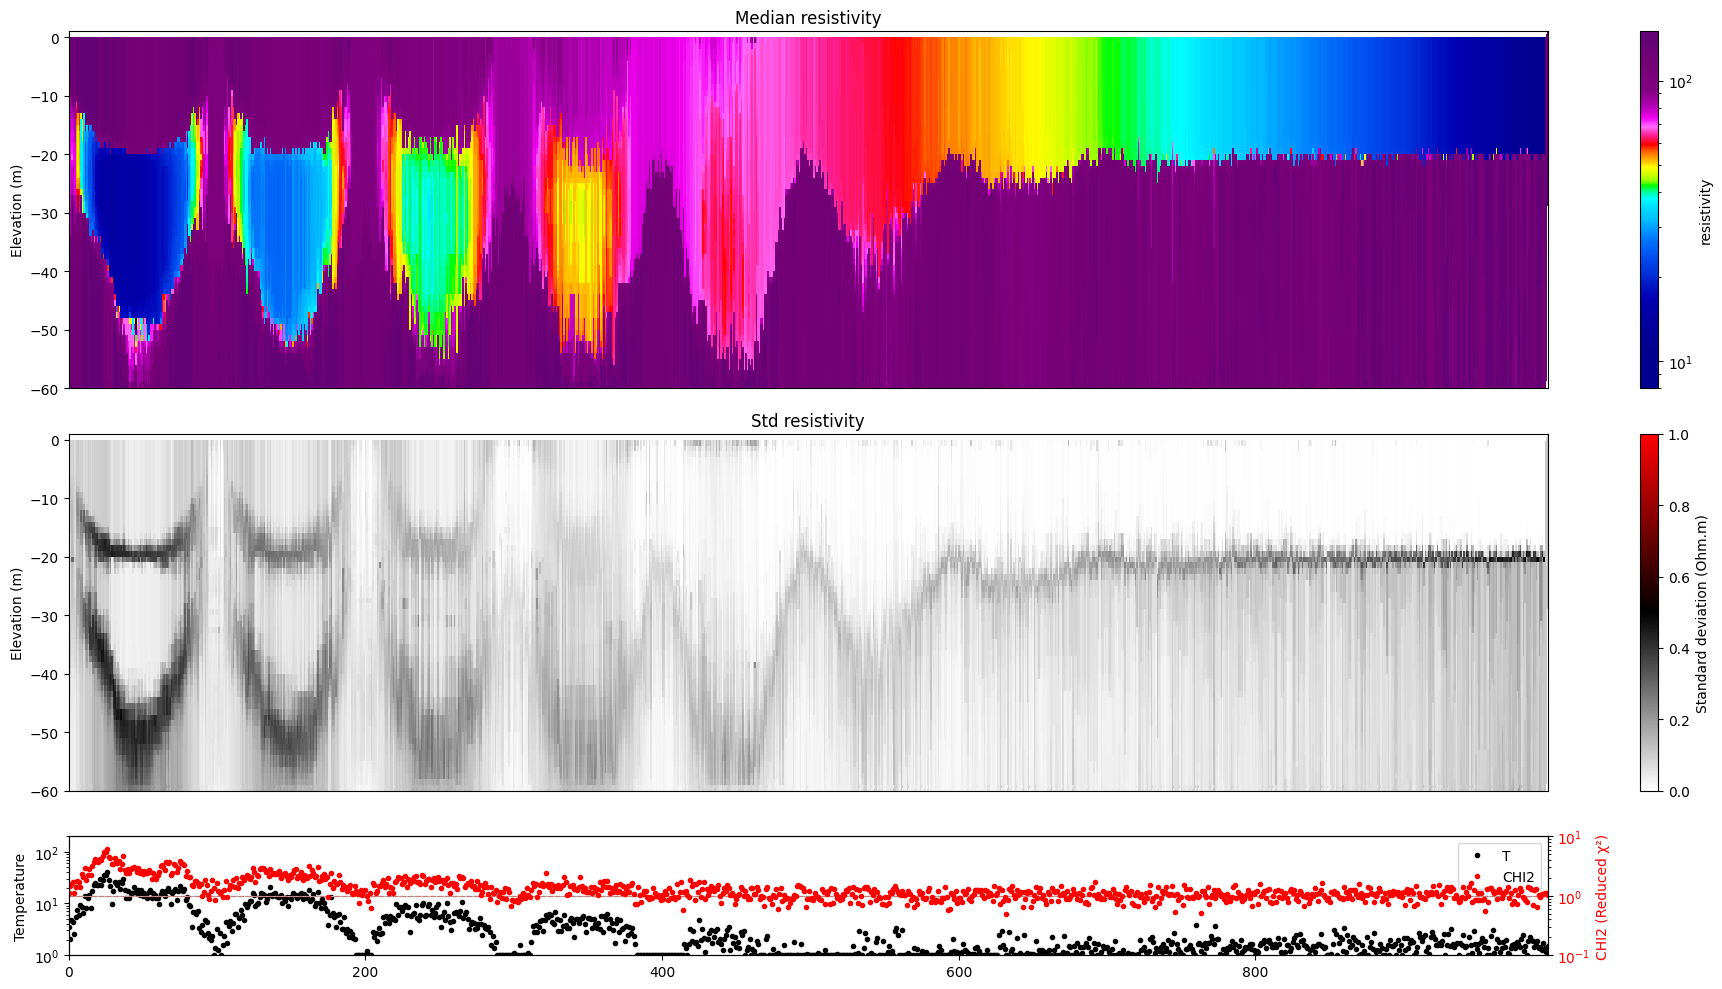

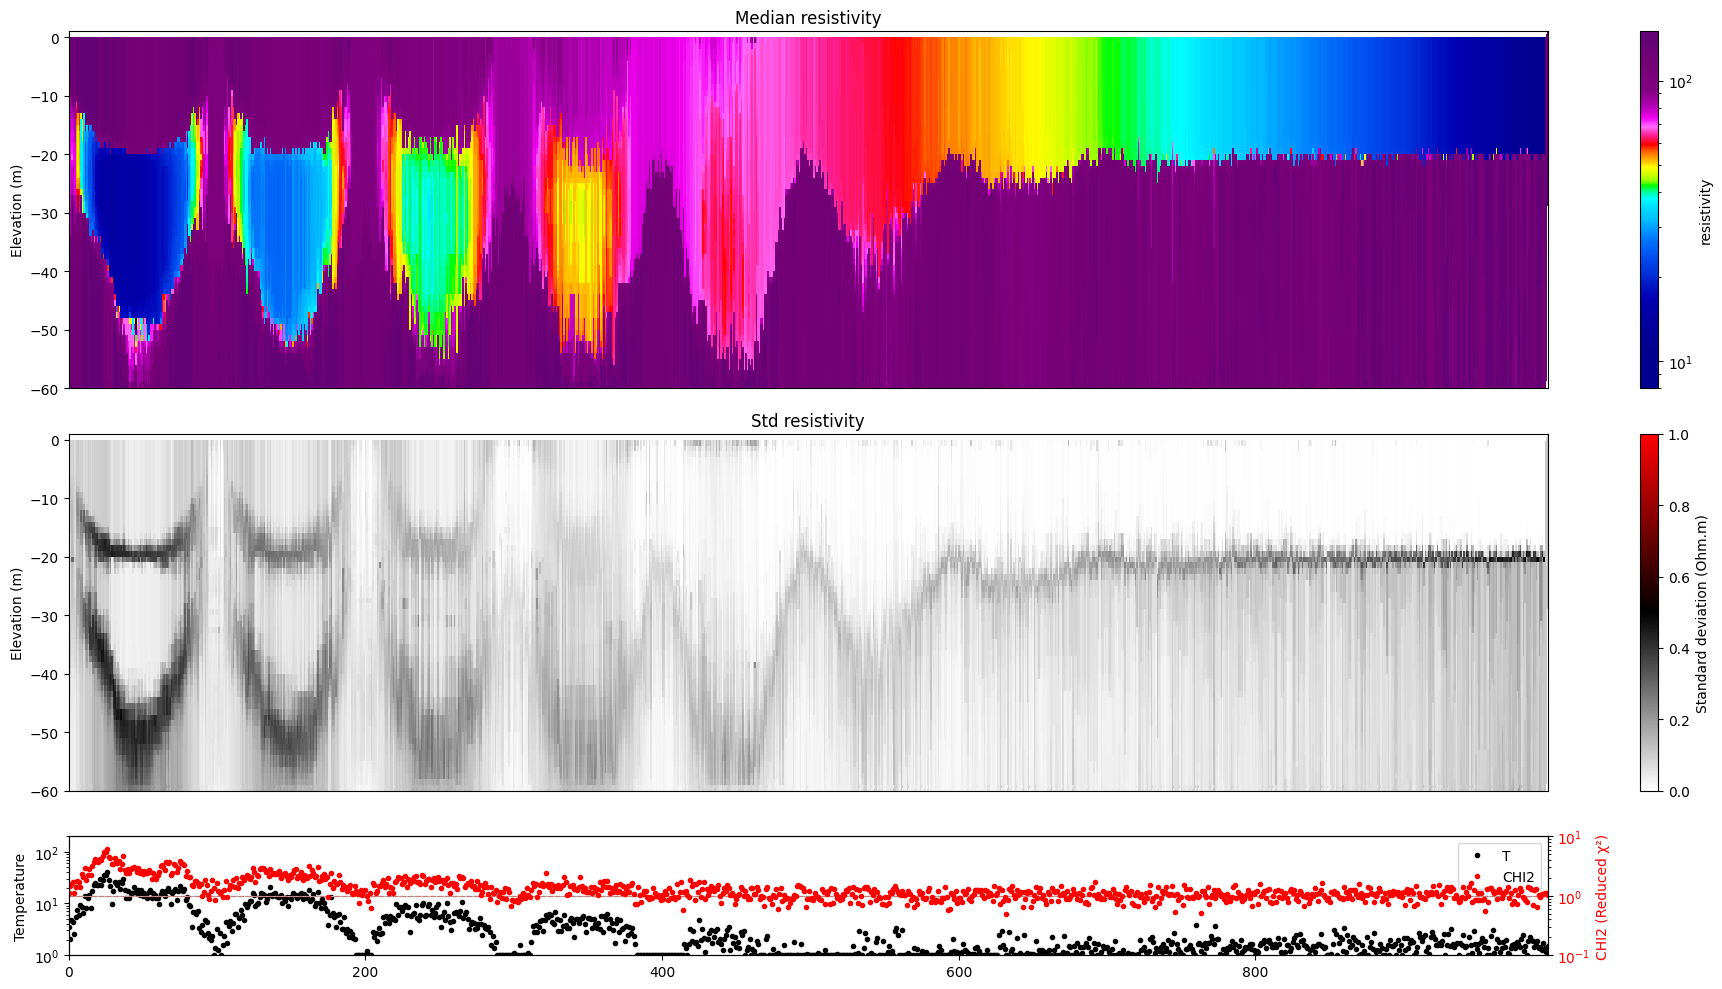

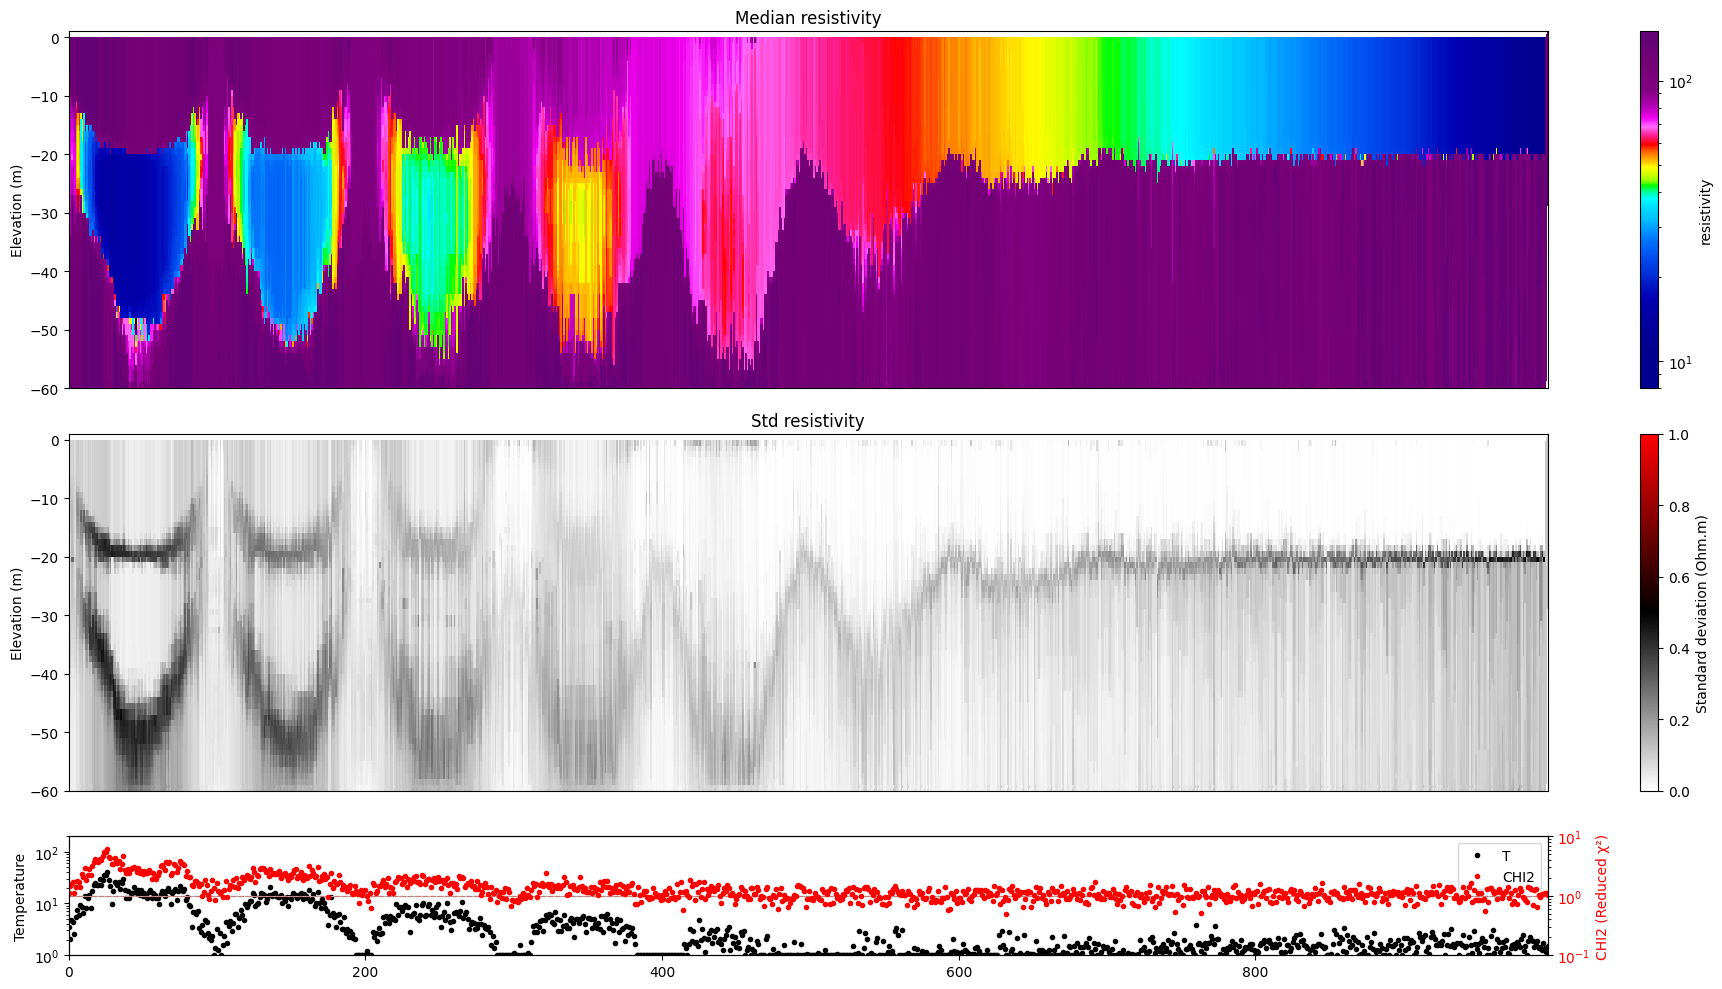

In [10]:
for i in range(len(f_post_h5_arr)):
    ig.plot_profile(f_post_h5_arr[i],hardcopy=hardcopy,  clim = clim, im=1)

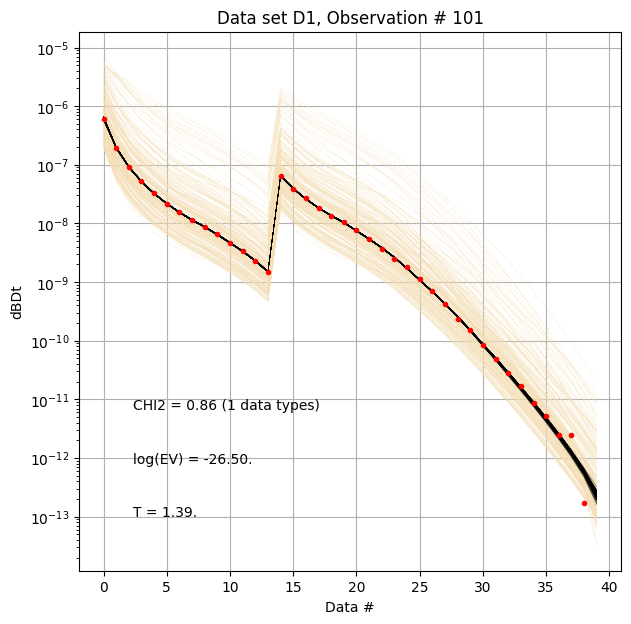

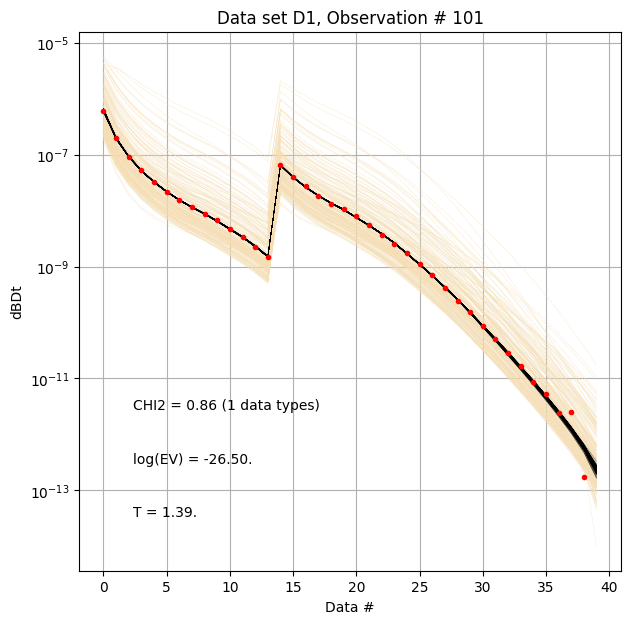

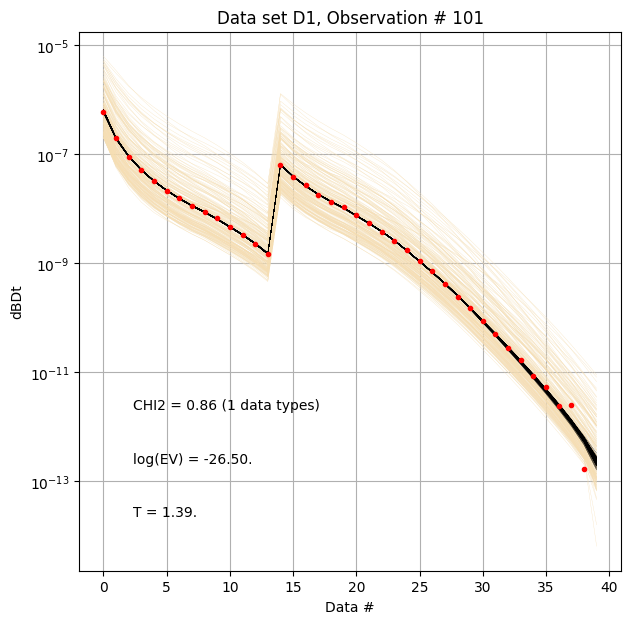

In [11]:
for i in range(len(f_post_h5_arr)):
    ig.plot_data_prior_post(f_post_h5_arr[0], i_plot=100, hardcopy=hardcopy)

Text(0, 0.5, 'EV_post')

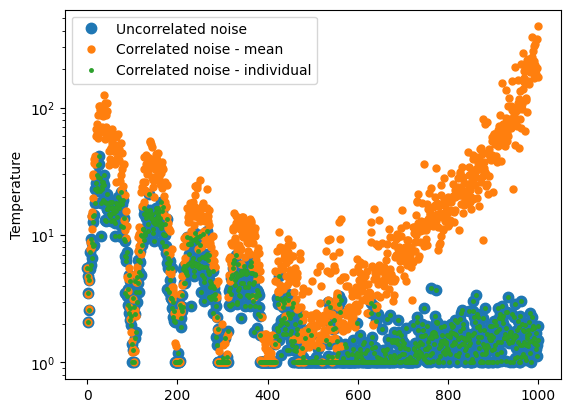

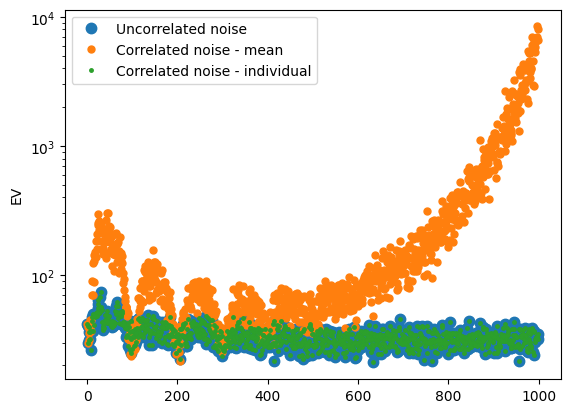

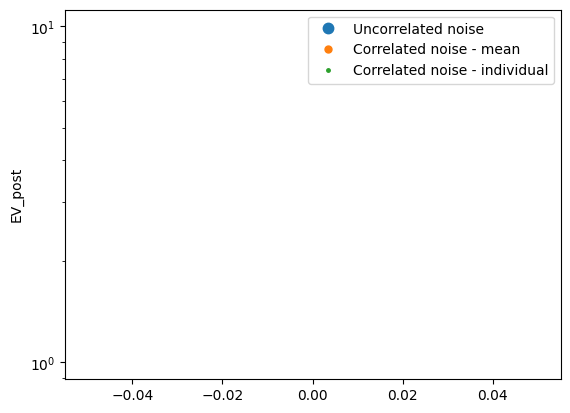

In [12]:
plt.figure()
for i in range(len(T_arr)):
    plt.semilogy(T_arr[i], '.', label=name_arr[i], markersize=15-5*i)
plt.legend()
plt.ylabel('Temperature')

plt.figure()
for i in range(len(T_arr)):
    plt.semilogy(-EV_arr[i], '.', label=name_arr[i], markersize=15-5*i)
plt.legend()
plt.ylabel('EV')


plt.figure()
for i in range(len(T_arr)):
    plt.semilogy(EV_post_arr[i], '.', label=name_arr[i], markersize=15-5*i)
plt.legend()
plt.ylabel('EV_post')



### Data in the log-space, and correlated Gaussian noise
The data can be transformed to the log-space, and the noise model can be applied in the log-space.


Data has 1000 stations and 40 channels
Adding group data_log_uncorr:D1 
Data has 1000 stations and 40 channels
Adding group data_log_corr:D1 
Data has 1000 stations and 40 channels
Adding group data_log_corr2:D1 


/tmp/ipykernel_200325/1068109233.py:8: RuntimeWarning: invalid value encountered in log10
  lD_std_down = np.abs(np.log10(D_ref-D_std)-lD_obs)


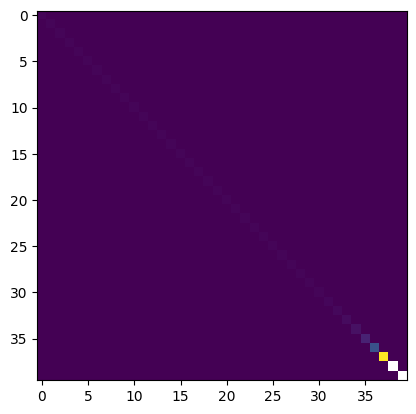

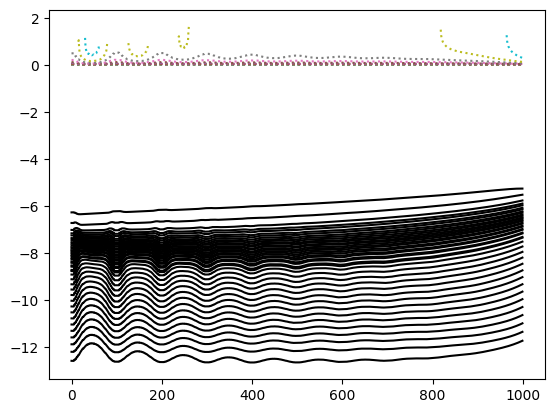

In [13]:

# Add constant covariance to Cd -->
# A simple way to introduce correlated noise
corrlev = 0.02**2

lD_obs = np.log10(D_ref)

lD_std_up = np.abs(np.log10(D_ref+D_std)-lD_obs)
lD_std_down = np.abs(np.log10(D_ref-D_std)-lD_obs)
lD_std = np.abs((lD_std_up+lD_std_down)/2) + np.sqrt(corrlev)

lCd_single = np.diag(np.mean(lD_std, axis=0)**2)+corrlev

plt.imshow(lCd_single)

ns,nd=D_std.shape
lCd_mul = np.zeros((ns,nd,nd))
for i in range(ns):
    lCd_mul[i] = np.diag(lD_std[i]**2)+corrlev

plt.figure()
plt.plot(lD_obs,'k-')
plt.plot(lD_std,':')


f_data_log_1_h5_f_out = ig.save_data_gaussian(lD_obs, D_std = lD_std, f_data_h5 = 'data_log_uncorr', id=1, showInfo=0, is_log=1, delete_if_exist=True)
f_data_log_2_h5_f_out = ig.save_data_gaussian(lD_obs, Cd = lCd_single, f_data_h5 = 'data_log_corr', id=1, showInfo=0, is_log=1, delete_if_exist=True)
f_data_log_3_h5_f_out = ig.save_data_gaussian(lD_obs, Cd = lCd_mul, f_data_h5 = 'data_log_corr2', id=1, showInfo=0, is_log=1, delete_if_exist=True)
f_data_arr = [f_data_log_1_h5_f_out,f_data_log_2_h5_f_out,f_data_log_3_h5_f_out]

In [14]:
lCd_single

array([[0.00149119, 0.0004    , 0.0004    , ..., 0.0004    , 0.0004    ,
        0.0004    ],
       [0.0004    , 0.00149124, 0.0004    , ..., 0.0004    , 0.0004    ,
        0.0004    ],
       [0.0004    , 0.0004    , 0.00149133, ..., 0.0004    , 0.0004    ,
        0.0004    ],
       ...,
       [0.0004    , 0.0004    , 0.0004    , ..., 0.08107004, 0.0004    ,
        0.0004    ],
       [0.0004    , 0.0004    , 0.0004    , ..., 0.0004    ,        nan,
        0.0004    ],
       [0.0004    , 0.0004    , 0.0004    , ..., 0.0004    , 0.0004    ,
               nan]], shape=(40, 40))

In [15]:
recomputePriorData = False
if recomputePriorData:
    f_prior_log_data_h5 = ig.prior_data_gaaem(f_prior_h5, file_gex, N=N-1, is_log=True)
else:
    # Simple load the old data and save it in log-space
    f_prior_log_data_h5  = 'd_log.h5'
    ig.copy_hdf5_file(f_prior_h5, f_prior_log_data_h5)
    D, idx = ig.load_prior_data(f_prior_data_h5); 
    Dlog = np.log10(D[0])
    ig.save_prior_data(f_prior_log_data_h5, Dlog, id=1)

Loading prior data from PRIOR_UNIFORM_NL_3-3_uniform_N2000000_TX07_20231016_2x4_RC20-33_Nh280_Nf12.h5. Using prior data ids: []
  - /D1:  N,nd = 2000000/40


/tmp/ipykernel_200325/2780609105.py:9: RuntimeWarning: invalid value encountered in log10
  Dlog = np.log10(D[0])


In [16]:
f_post_log_h5_arr = []
for i in range(len(f_data_arr)):
    f_data_h5 = f_data_arr[i]
    f_post_h5 = ig.integrate_rejection(f_prior_log_data_h5, f_data_h5, 
                                       parallel=parallel, 
                                       Ncpu=8,
                                       nr=1000,
                                       updatePostStat = True,                                       
                                    )
    f_post_log_h5_arr.append(f_post_h5)

integrate_rejection: Time=140.6s/1000 soundings, 140.6ms/sounding, 7.1it/s. T_av=1.2, EV_av=-11.5


integrate_rejection: Time=225.3s/1000 soundings, 225.3ms/sounding, 4.4it/s. T_av=1.1, EV_av=-10.1


integrate_rejection: Time=229.2s/1000 soundings, 229.2ms/sounding, 4.4it/s. T_av=1.1, EV_av=-10.2


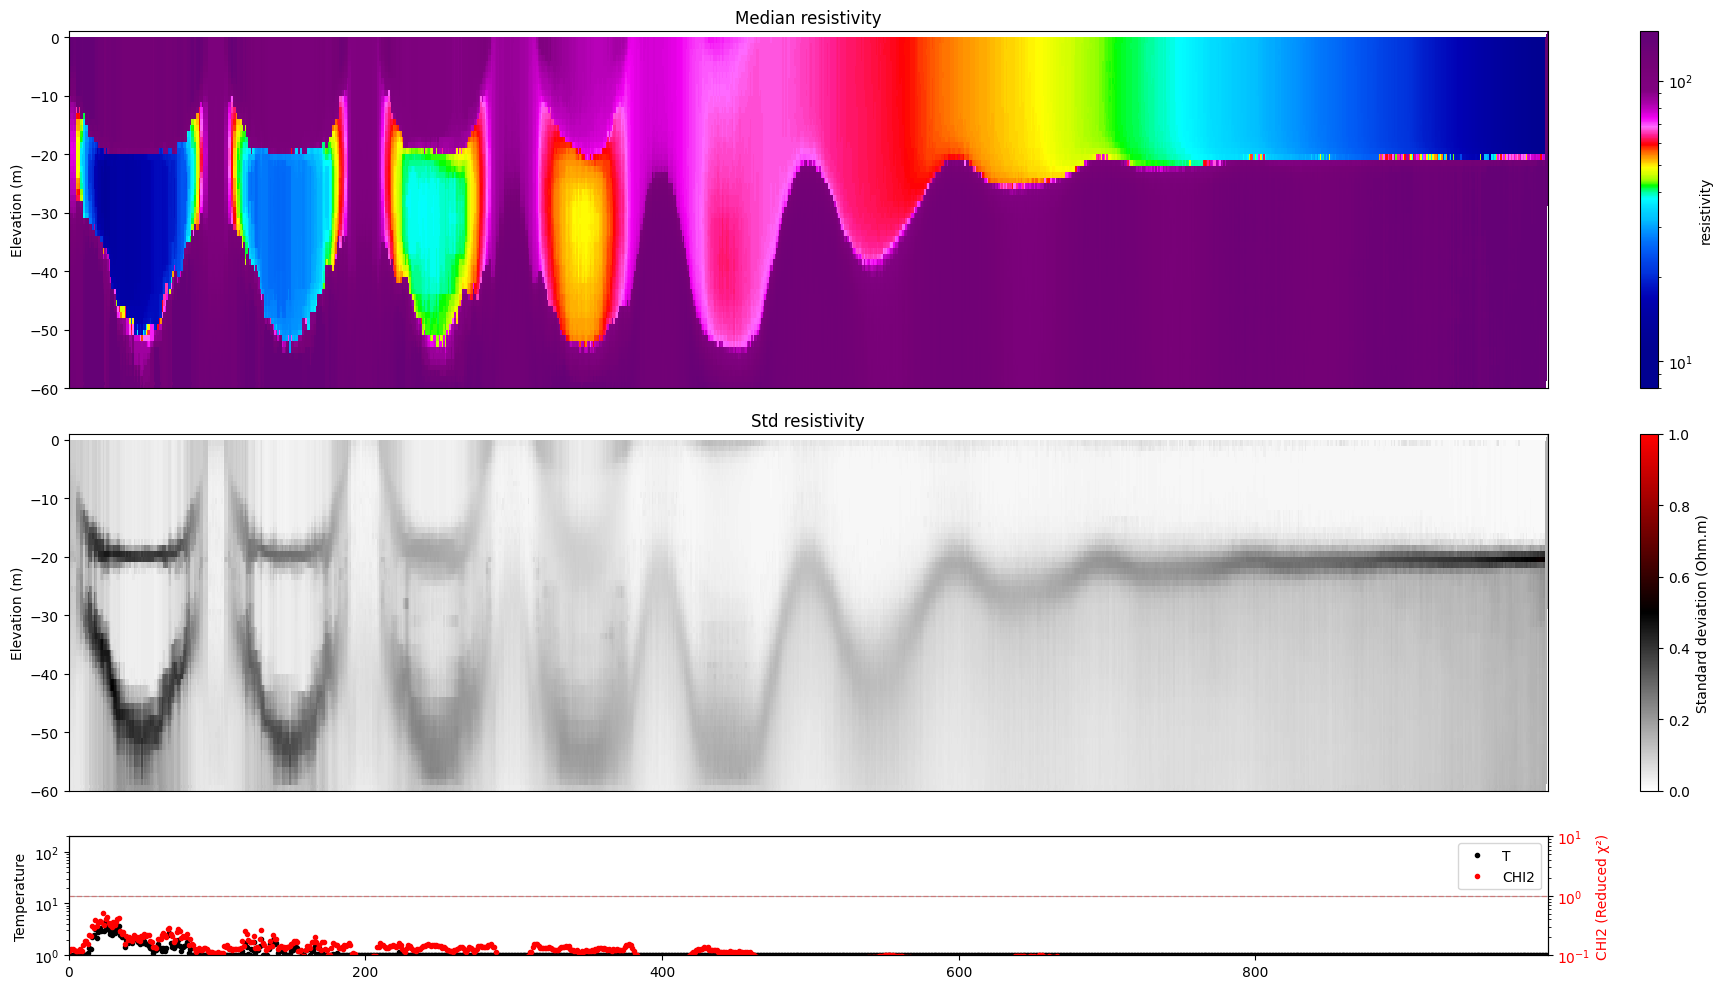

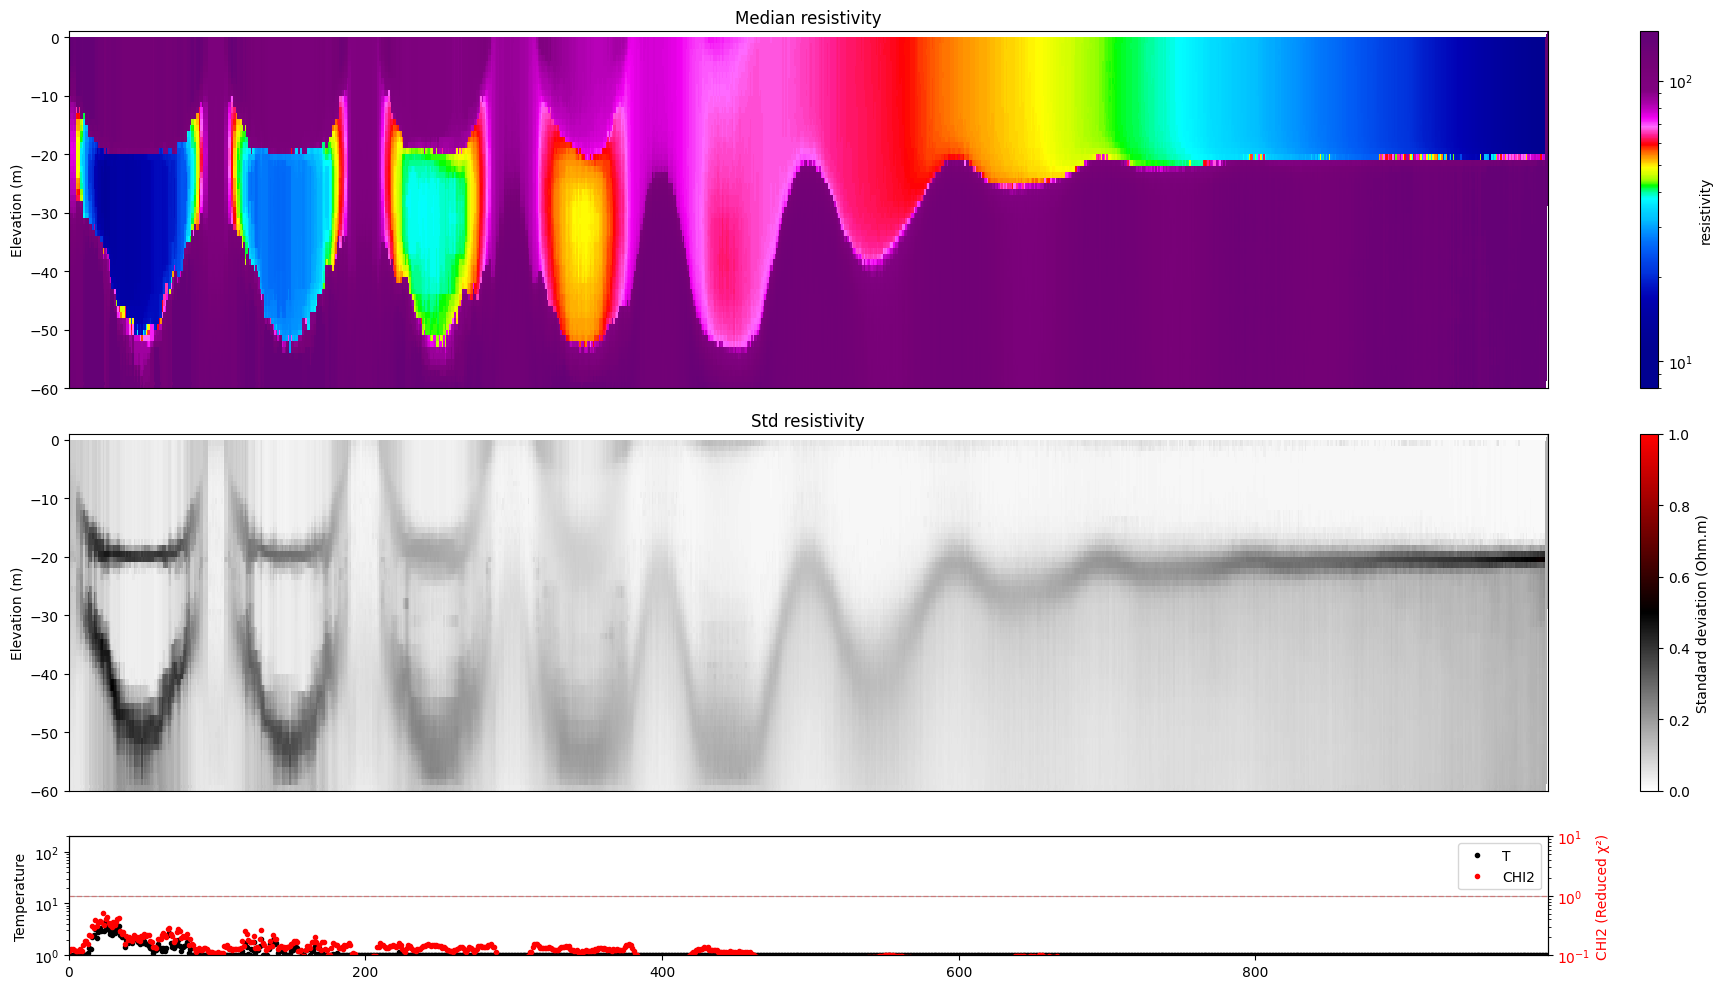

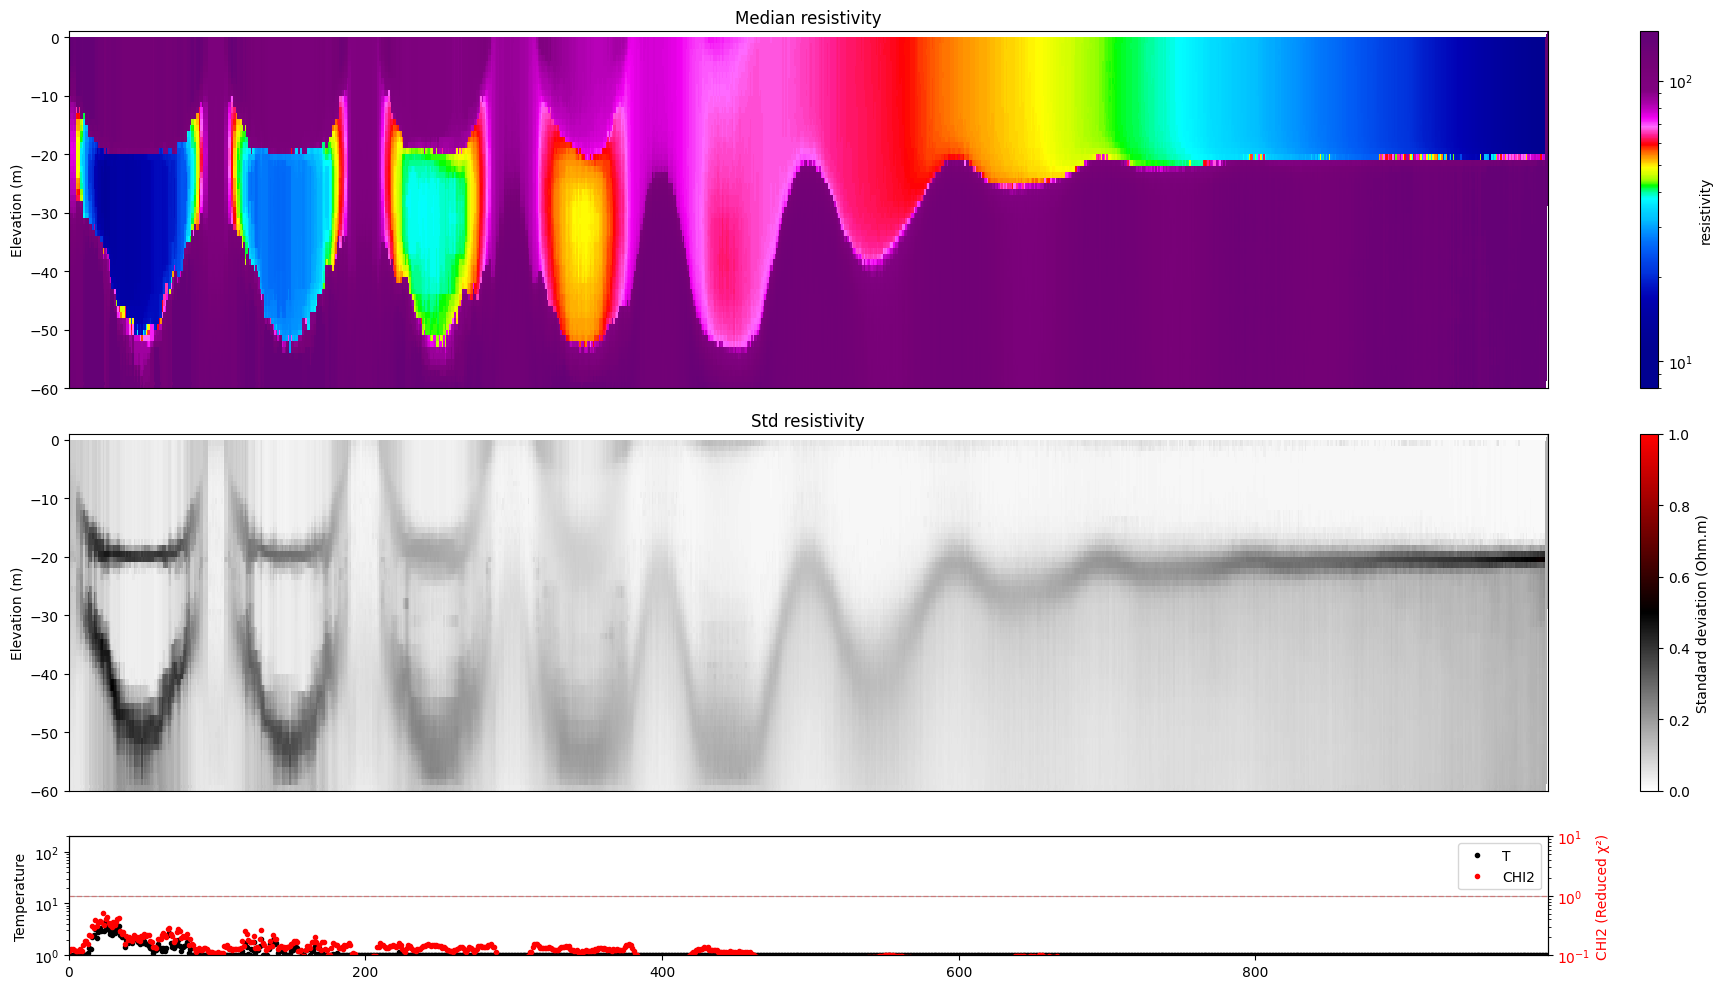

In [17]:
for i in range(len(f_post_log_h5_arr)):
    ig.plot_profile(f_post_log_h5_arr[i],hardcopy=hardcopy,  clim = clim, im=1)

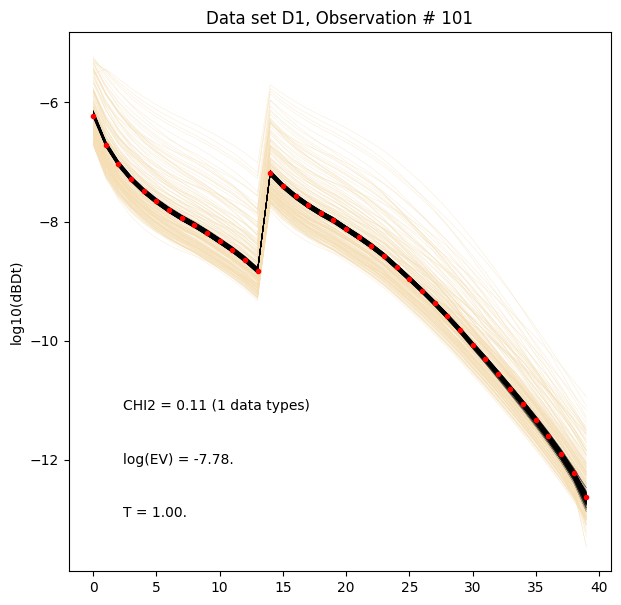

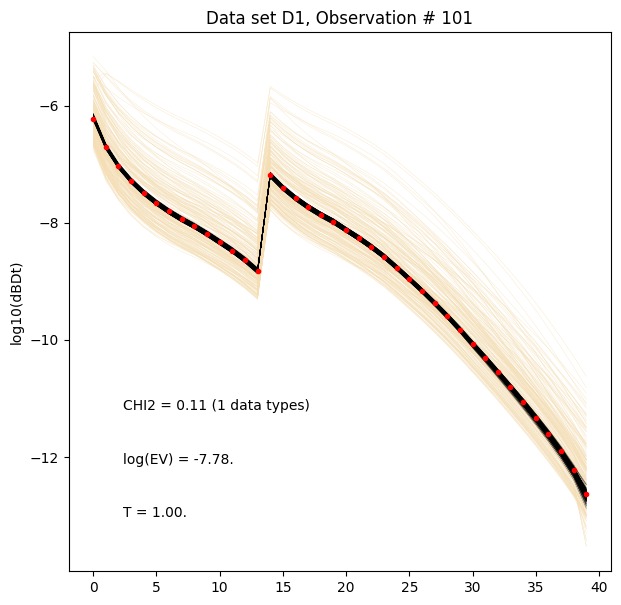

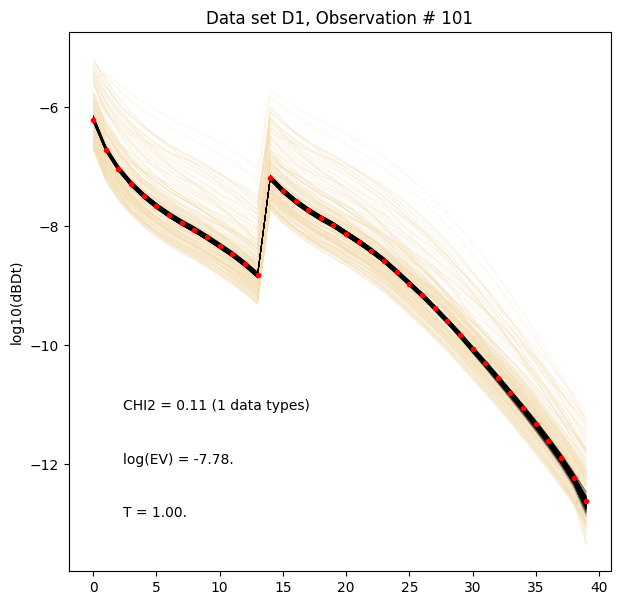

In [18]:

for i in range(len(f_post_log_h5_arr)):
    ig.plot_data_prior_post(f_post_log_h5_arr[i], i_plot=100, hardcopy=hardcopy, is_log=True)